In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_dataset = emotions['train']

In [5]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
train_dataset[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_dataset[2323]

{'text': 'i feel someone has been wronged when i feel i have been wronged or when i get riled up against an action i find offensive i unsheathe my sword and good lord you better look out',
 'label': 3}

In [8]:
train_dataset.features

{'text': Value('string'),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}

In [9]:
emotions.set_format(type='pandas')

In [10]:
df = emotions['train'][:]

In [11]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
df.shape

(16000, 2)

In [13]:
def label_int2str(row):
 return emotions["train"].features["label"].int2str(row)

In [14]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


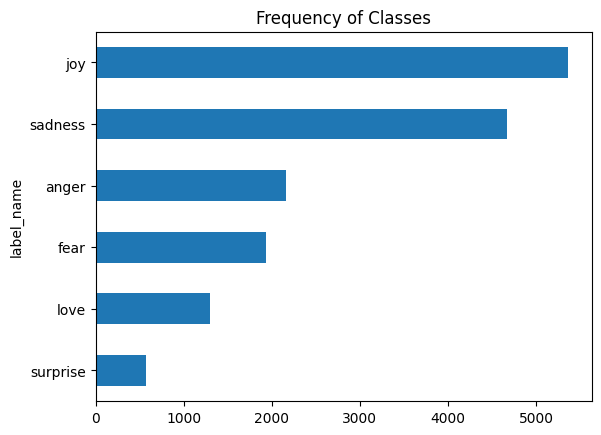

In [15]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

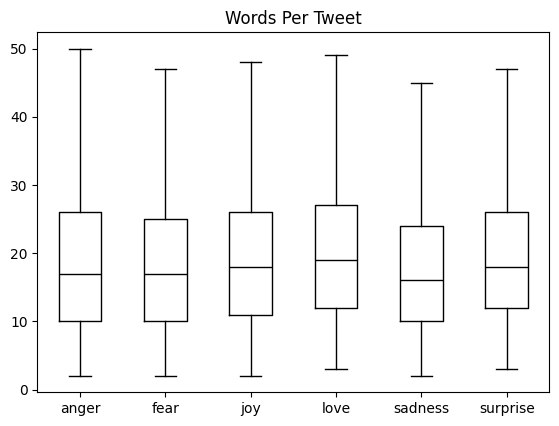

In [16]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
 showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [17]:
emotions.reset_format()

In [18]:
t = "Tokenizing text is a core task of NLP."
tokenized_text = list(t)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [19]:
token2idx = {token: idx for idx,token in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [20]:
input_idx = [token2idx[token] for token in tokenized_text]
print(input_idx)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [21]:
categorical_df = pd.DataFrame(
 {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [22]:
#one hot
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


In [23]:
import torch
import torch.nn.functional as F

In [24]:
input_ids = torch.tensor(input_idx)
one_hot_encoded = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encoded.shape

torch.Size([38, 20])

In [25]:
one_hot_encoded

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0,

In [26]:
#Word Tokenization
tokenized_text = t.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [27]:
from transformers import BertTokenizer # for bert tokonization
from transformers import AutoTokenizer # for other model --> distilbert

In [28]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [29]:
encoder_text = tokenizer(t)
print(encoder_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [30]:
tokens = tokenizer.convert_ids_to_tokens(encoder_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [31]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [32]:
tokenizer.vocab_size

30522

In [33]:
tokenizer.model_max_length

512

In [34]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [35]:
# whole dataset
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [36]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [37]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [38]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [39]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


### Transformers as Feature Extractors

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
from transformers import AutoTokenizer, AutoModel
import torch

In [42]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [43]:
# Encode a text
text = "ROS 2 is a communication system that allows for seamless communication between the various parts of a robot."
inputs = tokenizer(text, return_tensors="pt").to(device)
print(inputs)

{'input_ids': tensor([[  101, 20996,  2015,  1016,  2003,  1037,  4807,  2291,  2008,  4473,
          2005, 25180,  3238,  4807,  2090,  1996,  2536,  3033,  1997,  1037,
          8957,  1012,   102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


In [44]:
with torch.no_grad():
  outputs = model(**inputs)

In [45]:
# CLS token representation (embedding vector)
cls_embedding = outputs.last_hidden_state[:,0,:]
print(cls_embedding.shape)

torch.Size([1, 768])


In [46]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [47]:
def extract_hidden_states(batch):
  inputs = {k: v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}

  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  cls_embeddings = last_hidden_state[:,0].cpu().numpy()
  return {"hidden_state": cls_embeddings}

In [48]:
emotions_encoded.set_format('torch',columns =
                            ["input_ids", "attention_mask", "label"])

In [49]:
emotions_hidden = emotions_encoded.map(extract_hidden_states,batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [50]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [51]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [52]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train # Add the label column from y_train

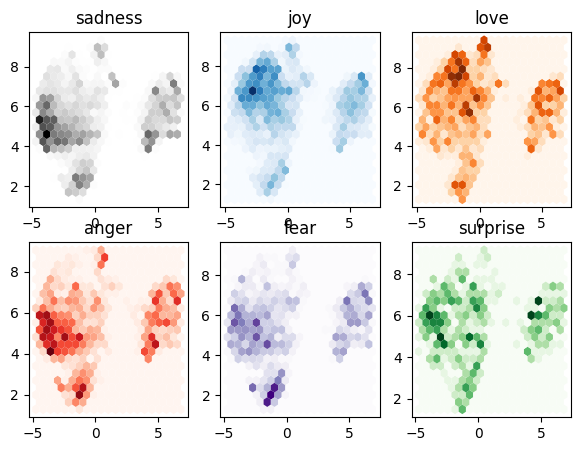

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                 gridsize=20, linewidths=(0,))
  axes[i].set_title(label)


In [54]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6345

In [55]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

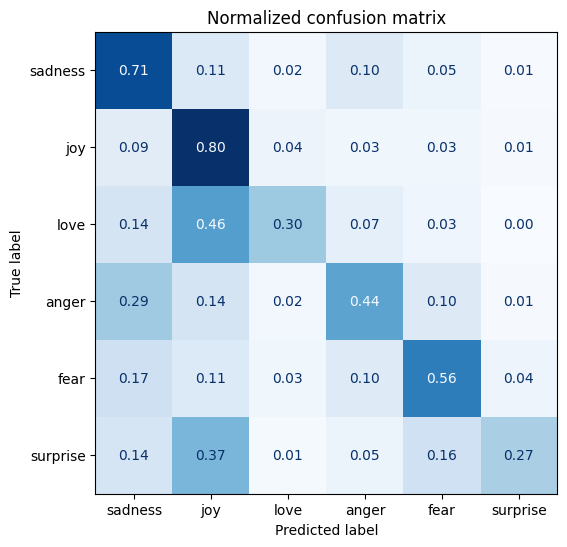

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

## Fine-Tuning Transformers

In [57]:
from transformers import AutoModelForSequenceClassification #not Automodel like featured-based approach it has calssification head on top the pretrained model outputs, which can be easily trained with the hbase model.
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [59]:
from huggingface_hub import notebook_login
notebook_login()

In [62]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
            num_train_epochs=2,
            learning_rate=2e-5,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            weight_decay=0.01,
            eval_strategy="epoch",
            disable_tqdm=False,
            logging_steps=logging_steps,
            push_to_hub=True,
            log_level="error")

In [63]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
      compute_metrics=compute_metrics,
      train_dataset=emotions_encoded["train"],
      eval_dataset=emotions_encoded["validation"],
      tokenizer=tokenizer)
trainer.train();

/tmp/ipython-input-3610536219.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nithingganesh1 (nithingganesh1-evolve-robotics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.803600,0.297742,0.912500,0.912478
2,0.241500,0.207663,0.926000,0.925888


In [64]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [65]:
preds_output.metrics

{'test_loss': 0.20766308903694153,
 'test_accuracy': 0.926,
 'test_f1': 0.9258875077999785,
 'test_runtime': 3.6731,
 'test_samples_per_second': 544.495,
 'test_steps_per_second': 8.712}

In [66]:
y_preds = np.argmax(preds_output.predictions, axis=1)

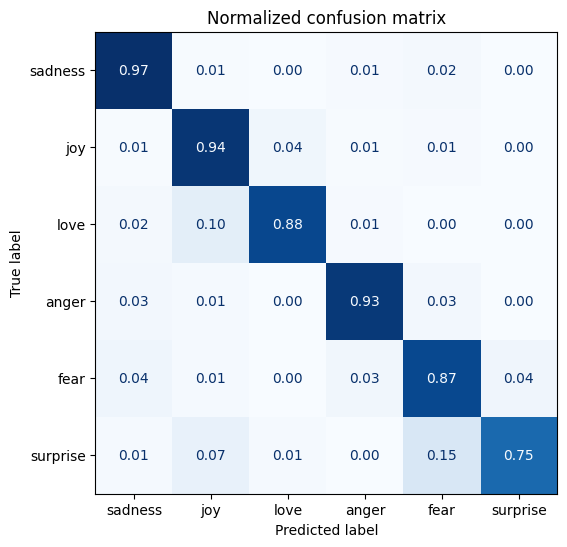

In [67]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [73]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
 # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
           if k in tokenizer.model_input_names}
    with torch.no_grad():
      output = model(**inputs)
      pred_label = torch.argmax(output.logits, axis=-1)
      loss = cross_entropy(output.logits, batch["label"].to(device),
                          reduction="none")
      # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),"predicted_label": pred_label.cpu().numpy()}

In [74]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
 columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
 forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [76]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [77]:
df_test.sort_values("loss", ascending=False).head(10) # higherst losess

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.703578
882,i feel badly about reneging on my commitment t...,love,sadness,5.526746
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.524234
1801,i feel that he was being overshadowed by the s...,love,sadness,5.445179
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.374856
1950,i as representative of everything thats wrong ...,surprise,sadness,5.327975
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.077916
1274,i am going to several holiday parties and i ca...,joy,sadness,4.595325
1111,im lazy my characters fall into categories of ...,joy,fear,4.594072
1509,i guess this is a memoir so it feels like that...,joy,fear,4.225835


In [78]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.015321
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.015445
267,i feel like im alone in missing him and becaus...,sadness,sadness,0.015553
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.015573
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.015647
697,i was missing him desperately and feeling idio...,sadness,sadness,0.015652
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.015741
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.015763
189,i leave the meeting feeling more than a little...,sadness,sadness,0.015816
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.015887


In [79]:
trainer.push_to_hub(commit_message="Training completed!")

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...finetuned-emotion/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...finetuned-emotion/model.safetensors:  13%|#2        | 33.5MB /  268MB            

  ...vents.1756177396.6bcde471f8be.537.0: 100%|##########| 6.67kB / 6.67kB            

CommitInfo(commit_url='https://huggingface.co/nithinganesh/distilbert-base-uncased-finetuned-emotion/commit/1fefc706ccf075e33258e2faafeda4e8b91fc863', commit_message='Training completed!', commit_description='', oid='1fefc706ccf075e33258e2faafeda4e8b91fc863', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nithinganesh/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='nithinganesh/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

In [81]:
#loading my model from hugging face
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "nithinganesh/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/837 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [82]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


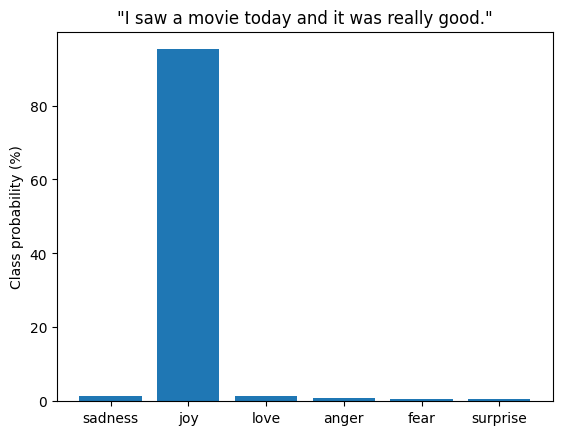

In [83]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()